***
### Tutorial to load a keras model with custom layer(s):

This notebook can be used to load the model with custom layer using the function `loading_pruned_model` available in the package. The necessary imports can be installed using the cell below. For all the classes that are not buint-in to the tensorflow/keras library, you have to use the `custom_objects` parameter to specify them so that when reading the .json file to ascertain the model architecture, the function `load_model_from_json` can identify any customized layers/operations. 

The format to declare the custom class object in the function call is `"Class/Function Name String": Class/ Function`. Example: for our custom layer the declaration is as follow: `"MaskedDense": MaskedDense`.
***

In [5]:
import tensorflow as tf 
import keras
import numpy as np
import pandas as pd
print(tf.__version__)
print(keras.__version__)
print(pd.__version__)
print(np.__version__)

from nn_globals import *
from nn_evaluate import get_sparsity,k_fold_validation
from nn_plotting import __generate_delta_plots__
from dataset import muon_data_split
from nn_pruning_module_support import loading_trained_model

from custom_dense_layer import MaskedDense
from keras.regularizers import l1_l2
from keras.initializers import glorot_uniform

2.6.0
2.6.0
1.3.4
1.19.5


In [6]:
pruned_model = loading_trained_model(filepath = "./models",
                                 model_filename = "custom_model_50",
                                 custom_objects ={'GlorotUniform': glorot_uniform(), 
                                                  "MaskedDense": MaskedDense, 
                                                  "L1L2": l1_l2()})
pruned_model.summary()
# baseline = loading_trained_model(filepath = "./models",
#                                  model_filename = "model")
# baseline.summary()

./models/custom_model_50.json
./models/custom_model_50_weights.h5
Metal device set to: Apple M1
Loaded model from disk
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 23)]              0         
_________________________________________________________________
batchnorm-1 (BatchNormalizat (None, 23)                92        
_________________________________________________________________
masked_dense-1 (MaskedDense) (None, 20)                460       
_________________________________________________________________
batchnorm-2 (BatchNormalizat (None, 20)                80        
_________________________________________________________________
layer_activation-1 (Activati (None, 20)                0         
_________________________________________________________________
masked_dense-2 (MaskedDense) (None, 15)                300       
______

2022-01-11 11:26:39.569324: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-11 11:26:39.569475: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# verify the sparsity of loaded pruned model
for layer in pruned_model.layers:
    if "dense" in layer.name:
        print("Sparsity of the {} layer is = {}".format(layer.name, get_sparsity(layer.get_weights()[0])))

Sparsity of the masked_dense-1 layer is = 0.5
Sparsity of the masked_dense-2 layer is = 0.5
Sparsity of the masked_dense-3 layer is = 0.5
Sparsity of the output_dense layer is = 0.0


***
### Evaluating the model:
To use the model for prediction, suggestion is to use the functions available in `nn_evaluate` file. The code to preprocess the data can be used to load and extract relevant features from the raw file. **NOTE:** file path to the data needs to be edited in the `nn_globals.py` in place of variable `DATAFILEPATH`.
***

In [4]:
from dataset import muon_data_split
# Import muon data
# 'x' is the array of input variables, 'y' is the q/pT
x, y, dxy = muon_data_split(filename=DATAFILEPATH, 
                           reg_pt_scale=REG_PT_SCALE, 
                           reg_dxy_scale=REG_DXY_SCALE, 
                           test_size=0,
                           nvariables = NVARIABLES,
                           nentries= NENTRIES,
                           batch_size = 128)


[INFO    ] Loading muon data from ./data/NN_input_params_FlatXYZ.npz ...
[INFO    ] Loaded the variables with shape (19300000, 25)
[INFO    ] Loaded the parameters with shape (19300000, 6)
[INFO    ] Loaded the encoded variables with shape (3284620, 23)
[INFO    ] Loaded the encoded parameters with shape (3284620,)


***
With `k_fold_validation`, using `metric_type` argument, we can change the type of evaluation metric. It can be `["RMSE", "MAE", "MAPE"]`

Using `__generate_delta_plots__` we can get a gaussian approximation for the errors for momentum and angular displacement.
***

In [8]:
k_fold_validation(model = pruned_model,
                    x = x,
                    y = y,
                    dxy = dxy,
                    folds=1,
                    eval_batch_size=2000,
                    metric_type='RMSE')

2022-01-11 11:26:48.189643: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-11 11:26:48.190464: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-11 11:26:48.246970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Mean RMSE for 1-Fold cv for momentum = 51.76876156662062
Mean RMSE for 1-Fold cv for displacement = 16.230001300427038


In [10]:
k_fold_validation(model = pruned_model,
                    x = x,
                    y = y,
                    dxy = dxy,
                    folds=1,
                    eval_batch_size=2000,
                    metric_type='MAE')

Mean MAE for 1-Fold cv for momentum = 11.098079075131475
Mean MAE for 1-Fold cv for displacement = 11.430090984665341


[INFO    ] # of entries: 3284620, mean: 0.04249732642478677, std: 0.18463903659635786
[INFO    ] gaus fit (a, mu, sig): [1.72080926e+05 6.53609836e-03 2.50802381e-01]


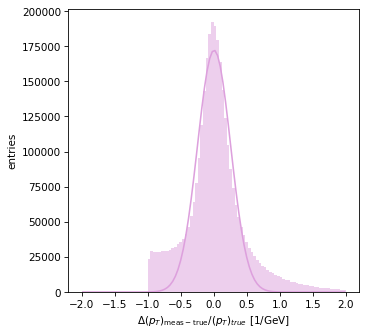

[INFO    ] # of entries: 477217, mean: -0.12754184089952086, std: 10.251226219050828
[INFO    ] gaus fit (a, mu, sig): [ 2.92398123e+04 -1.93164363e-01  5.91321329e+00]


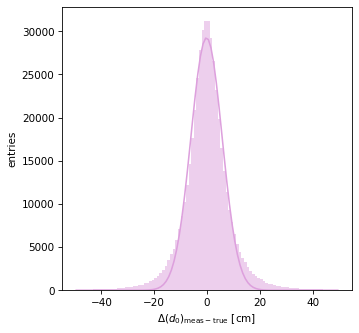

In [11]:
__generate_delta_plots__(model = pruned_model,
                        x = x,
                        y = y,
                        dxy = dxy,
                        color='plum',
                        batch_size = 4096,
                        min_y_val= 20.0)